In [5]:
import pyupbit
import pandas as pd
from tqdm import tqdm

# 불러올 종목 리스트 (예: BTC, ETH, ADA 등)
tickers = ["KRW-BTC", "KRW-ETH", "KRW-ADA", "KRW-XRP", "KRW-DOT",
           "KRW-BCH", "KRW-LTC", "KRW-ETC", "KRW-EOS", "KRW-TRX"]

# 데이터를 저장할 딕셔너리
data = {}

# 각 종목에 대해 일봉 데이터를 불러오기
for ticker in tqdm(tickers):
    df = pyupbit.get_ohlcv(ticker, interval="day", count=20000)
    data[ticker] = df

# 데이터프레임으로 변환
data_df = pd.concat(data, axis=1)


100%|██████████| 10/10 [10:28<00:00, 62.84s/it]


In [24]:
data_df = data_df['KRW-BTC']

In [29]:
data_df = data_df.drop('value', axis = 1)


In [38]:
df_cleaned = data_df

In [45]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class CryptoTradingEnv(gym.Env):
    def __init__(self, data):
        super(CryptoTradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.initial_balance = 1000000  # 초기 자본금
        self.balance = self.initial_balance
        self.portfolio = 0
        self.total_value = self.initial_balance

        # 관측 공간과 행동 공간 정의
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(6,), dtype=np.float32)
        self.action_space = spaces.Discrete(3)  # 세 가지 행동: 0=유지, 1=매수, 2=매도
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            np.random.seed(seed)
        self.balance = self.initial_balance
        self.portfolio = 0
        self.current_step = 0
        self.total_value = self.initial_balance
        return self._next_observation(), {}
    
    def _next_observation(self):
        obs = self.data.iloc[self.current_step][['open', 'high', 'low', 'close', 'volume']].to_numpy(dtype=np.float32)
        obs = np.append(obs, self.balance).astype(np.float32)
        return obs
    
    def step(self, action):
        self._take_action(action)
        self.current_step += 1
        if self.current_step >= len(self.data):
            self.current_step = 0

        obs = self._next_observation()
        reward = self.total_value - self.initial_balance
        terminated = bool(self.total_value <= 0)
        truncated = False  # 추가 종료 조건이 없는 경우 False로 설정
        return obs, float(reward), terminated, truncated, {}
    
    def _take_action(self, action):
        current_price = self.data.iloc[self.current_step]['close']
        if action == 1 and self.balance > 0:  # 매수
            self.portfolio += self.balance / current_price
            self.balance = 0
        elif action == 2 and self.portfolio > 0:  # 매도
            self.balance += self.portfolio * current_price
            self.portfolio = 0
        self.total_value = self.balance + self.portfolio * current_price

env = CryptoTradingEnv(df_cleaned)


In [46]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

# 환경 체크
check_env(env)

# 모델 정의 및 학습
model = DQN("MlpPolicy", env, verbose=1, learning_rate=1e-3, buffer_size=50000, learning_starts=1000, batch_size=32, tau=1e-2, target_update_interval=1000)
model.learn(total_timesteps=5000)

# 학습된 모델 저장
model.save("dqn_cryptotrading_model")

# 모델 로드
model = DQN.load("dqn_cryptotrading_model")

# 강화학습 모델의 포트폴리오 가치 계산
rl_values = []

obs, _ = env.reset()
for _ in range(len(df_cleaned)):
    action, _states = model.predict(obs)
    obs, rewards, terminated, truncated, _ = env.step(action)
    rl_values.append(env.total_value)
    if terminated or truncated:
        break

rl_values = np.array(rl_values)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Buy-and-Hold 전략의 변동성: 0.5459021981407917
강화학습 모델의 변동성: 0.5310201397581612
Buy-and-Hold 전략의 샤프 지수: 0.8275371999538551
강화학습 모델의 샤프 지수: 0.6784878278821486


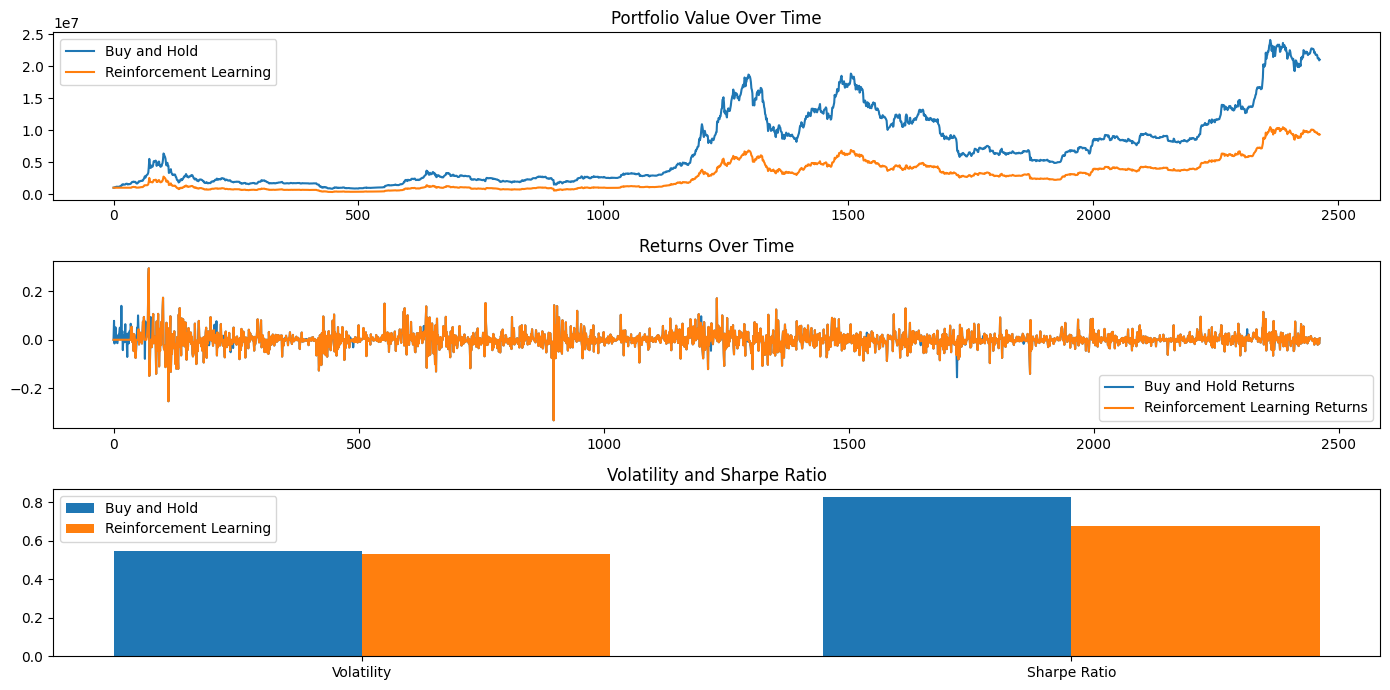

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_buy_and_hold(data, initial_balance=1000000):
    initial_price = data.iloc[0]['close']
    portfolio = initial_balance / initial_price
    
    portfolio_values = []
    for i in range(len(data)):
        current_price = data.iloc[i]['close']
        total_value = portfolio * current_price
        portfolio_values.append(total_value)
    
    return np.array(portfolio_values)

buy_and_hold_values = simulate_buy_and_hold(df_cleaned)

# 강화학습 모델의 포트폴리오 가치 계산
rl_values = []

obs, _ = env.reset()
for _ in range(len(df_cleaned)):
    action, _states = model.predict(obs)
    obs, rewards, terminated, truncated, _ = env.step(action)
    rl_values.append(env.total_value)
    if terminated or truncated:
        break

rl_values = np.array(rl_values)

# 수익률 계산
def calculate_returns(values):
    returns = (values[1:] - values[:-1]) / values[:-1]
    return returns

buy_and_hold_returns = calculate_returns(buy_and_hold_values)
rl_returns = calculate_returns(rl_values)

# 변동성 및 샤프 지수 계산
def calculate_sharpe_ratio(returns, risk_free_rate=0.01):
    excess_returns = returns - risk_free_rate / 252  # assuming daily returns
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    return sharpe_ratio

buy_and_hold_volatility = np.std(buy_and_hold_returns) * np.sqrt(252)
rl_volatility = np.std(rl_returns) * np.sqrt(252)

buy_and_hold_sharpe = calculate_sharpe_ratio(buy_and_hold_returns)
rl_sharpe = calculate_sharpe_ratio(rl_returns)

print(f"Buy-and-Hold 전략의 변동성: {buy_and_hold_volatility}")
print(f"강화학습 모델의 변동성: {rl_volatility}")
print(f"Buy-and-Hold 전략의 샤프 지수: {buy_and_hold_sharpe}")
print(f"강화학습 모델의 샤프 지수: {rl_sharpe}")

# 시각화
plt.figure(figsize=(14, 7))

# 포트폴리오 가치 변화
plt.subplot(3, 1, 1)
plt.plot(buy_and_hold_values, label="Buy and Hold")
plt.plot(rl_values, label="Reinforcement Learning")
plt.title("Portfolio Value Over Time")
plt.legend()

# 수익률 변화
plt.subplot(3, 1, 2)
plt.plot(buy_and_hold_returns, label="Buy and Hold Returns")
plt.plot(rl_returns, label="Reinforcement Learning Returns")
plt.title("Returns Over Time")
plt.legend()

# 변동성 및 샤프 지수
metrics = ['Volatility', 'Sharpe Ratio']
buy_and_hold_metrics = [buy_and_hold_volatility, buy_and_hold_sharpe]
rl_metrics = [rl_volatility, rl_sharpe]

x = np.arange(len(metrics))
width = 0.35

plt.subplot(3, 1, 3)
plt.bar(x - width/2, buy_and_hold_metrics, width, label="Buy and Hold")
plt.bar(x + width/2, rl_metrics, width, label="Reinforcement Learning")
plt.title("Volatility and Sharpe Ratio")
plt.xticks(x, metrics)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def calculate_returns(values):
    returns = (values[1:] - values[:-1]) / values[:-1]
    return returns

buy_and_hold_returns = calculate_returns(buy_and_hold_values)
rl_returns = calculate_returns(rl_values)


In [ ]:
def calculate_sharpe_ratio(returns, risk_free_rate=0.01):
    excess_returns = returns - risk_free_rate / 252  # assuming daily returns
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    return sharpe_ratio

buy_and_hold_volatility = np.std(buy_and_hold_returns) * np.sqrt(252)
rl_volatility = np.std(rl_returns) * np.sqrt(252)

buy_and_hold_sharpe = calculate_sharpe_ratio(buy_and_hold_returns)
rl_sharpe = calculate_sharpe_ratio(rl_returns)

print(f"Buy-and-Hold 전략의 변동성: {buy_and_hold_volatility}")
print(f"강화학습 모델의 변동성: {rl_volatility}")
print(f"Buy-and-Hold 전략의 샤프 지수: {buy_and_hold_sharpe}")
print(f"강화학습 모델의 샤프 지수: {rl_sharpe}")


In [ ]:
plt.figure(figsize=(14, 7))

# 포트폴리오 가치 변화
plt.subplot(3, 1, 1)
plt.plot(buy_and_hold_values, label="Buy and Hold")
plt.plot(rl_values, label="Reinforcement Learning")
plt.title("Portfolio Value Over Time")
plt.legend()

# 수익률 변화
plt.subplot(3, 1, 2)
plt.plot(buy_and_hold_returns, label="Buy and Hold Returns")
plt.plot(rl_returns, label="Reinforcement Learning Returns")
plt.title("Returns Over Time")
plt.legend()

# 변동성 및 샤프 지수
metrics = ['Volatility', 'Sharpe Ratio']
buy_and_hold_metrics = [buy_and_hold_volatility, buy_and_hold_sharpe]
rl_metrics = [rl_volatility, rl_sharpe]

x = np.arange(len(metrics))
width = 0.35

plt.subplot(3, 1, 3)
plt.bar(x - width/2, buy_and_hold_metrics, width, label="Buy and Hold")
plt.bar(x + width/2, rl_metrics, width, label="Reinforcement Learning")
plt.title("Volatility and Sharpe Ratio")
plt.xticks(x, metrics)
plt.legend()

plt.tight_layout()
plt.show()


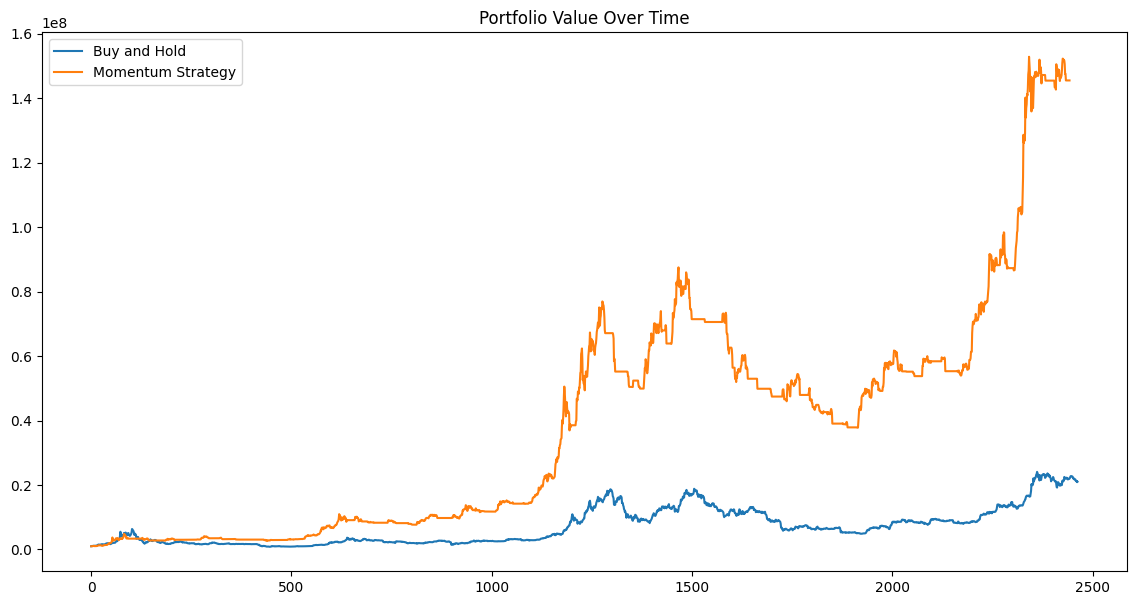

In [50]:
import numpy as np

def momentum_strategy(data, lookback=20, initial_balance=1000000):
    data['return'] = data['close'].pct_change()
    data['momentum'] = data['return'].rolling(window=lookback).mean()

    balance = initial_balance
    portfolio = 0
    values = []

    for i in range(lookback, len(data)):
        current_price = data.iloc[i]['close']
        momentum = data.iloc[i]['momentum']

        # 모멘텀 신호가 양수이면 매수, 음수이면 매도
        if momentum > 0 and balance > 0:
            portfolio += balance / current_price
            balance = 0
        elif momentum < 0 and portfolio > 0:
            balance += portfolio * current_price
            portfolio = 0

        total_value = balance + portfolio * current_price
        values.append(total_value)
    
    return np.array(values)

momentum_values = momentum_strategy(df_cleaned)

# Buy-and-Hold 전략 비교
def simulate_buy_and_hold(data, initial_balance=1000000):
    initial_price = data.iloc[0]['close']
    portfolio = initial_balance / initial_price
    
    portfolio_values = []
    for i in range(len(data)):
        current_price = data.iloc[i]['close']
        total_value = portfolio * current_price
        portfolio_values.append(total_value)
    
    return np.array(portfolio_values)

buy_and_hold_values = simulate_buy_and_hold(df_cleaned)

# 결과 비교
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# 포트폴리오 가치 변화
plt.plot(buy_and_hold_values, label="Buy and Hold")
plt.plot(momentum_values, label="Momentum Strategy")
plt.title("Portfolio Value Over Time")
plt.legend()
plt.show()


Buy-and-Hold 전략의 변동성: 0.5459021981407917
모멘텀 전략의 변동성: 0.40249400588550155
강화학습 모델의 변동성: 0.5310201397581612
Buy-and-Hold 전략의 샤프 지수: 0.8275371999538551
모멘텀 전략의 샤프 지수: 1.4500142166755086
강화학습 모델의 샤프 지수: 0.6784878278821486


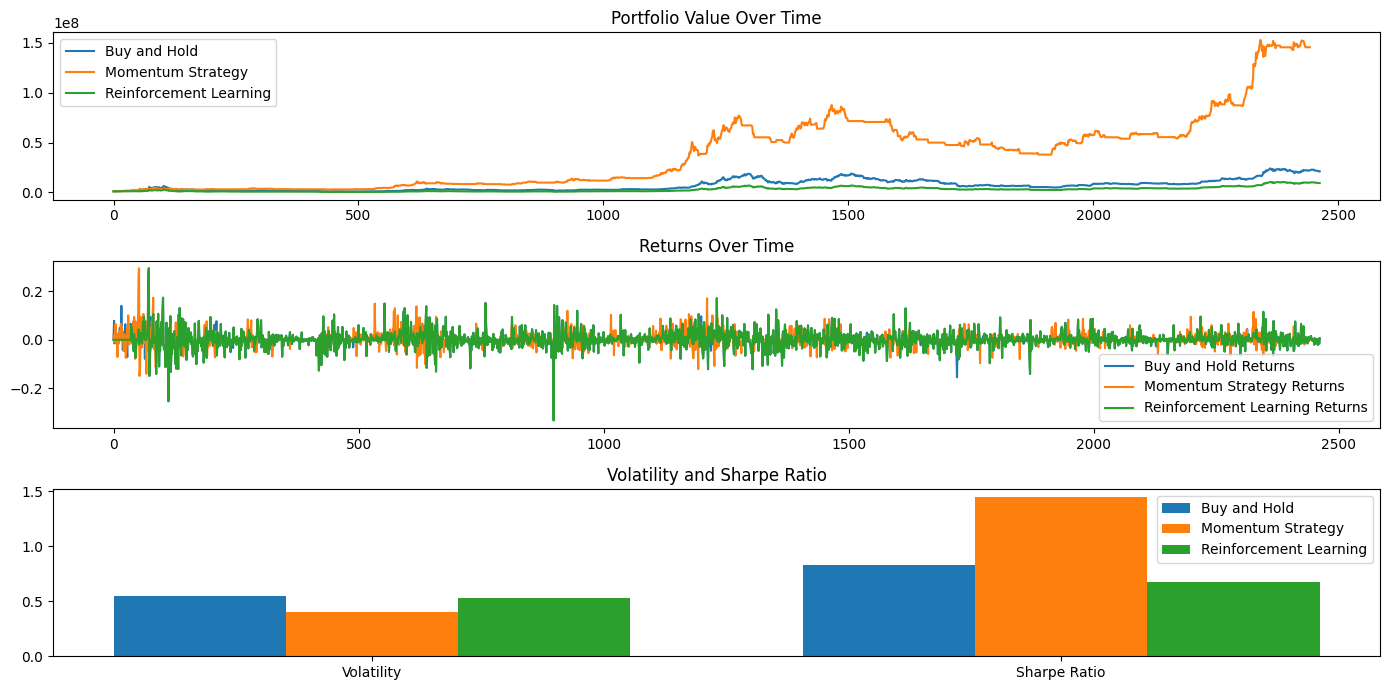

In [52]:
# 수익률 계산
def calculate_returns(values):
    returns = (values[1:] - values[:-1]) / values[:-1]
    return returns

buy_and_hold_returns = calculate_returns(buy_and_hold_values)
momentum_returns = calculate_returns(momentum_values)
rl_returns = calculate_returns(rl_values)

# 변동성 및 샤프 지수 계산
def calculate_sharpe_ratio(returns, risk_free_rate=0.01):
    excess_returns = returns - risk_free_rate / 252  # assuming daily returns
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    return sharpe_ratio

buy_and_hold_volatility = np.std(buy_and_hold_returns) * np.sqrt(252)
momentum_volatility = np.std(momentum_returns) * np.sqrt(252)
rl_volatility = np.std(rl_returns) * np.sqrt(252)

buy_and_hold_sharpe = calculate_sharpe_ratio(buy_and_hold_returns)
momentum_sharpe = calculate_sharpe_ratio(momentum_returns)
rl_sharpe = calculate_sharpe_ratio(rl_returns)

print(f"Buy-and-Hold 전략의 변동성: {buy_and_hold_volatility}")
print(f"모멘텀 전략의 변동성: {momentum_volatility}")
print(f"강화학습 모델의 변동성: {rl_volatility}")
print(f"Buy-and-Hold 전략의 샤프 지수: {buy_and_hold_sharpe}")
print(f"모멘텀 전략의 샤프 지수: {momentum_sharpe}")
print(f"강화학습 모델의 샤프 지수: {rl_sharpe}")

# 시각화
plt.figure(figsize=(14, 7))

# 포트폴리오 가치 변화
plt.subplot(3, 1, 1)
plt.plot(buy_and_hold_values, label="Buy and Hold")
plt.plot(momentum_values, label="Momentum Strategy")
plt.plot(rl_values, label="Reinforcement Learning")
plt.title("Portfolio Value Over Time")
plt.legend()

# 수익률 변화
plt.subplot(3, 1, 2)
plt.plot(buy_and_hold_returns, label="Buy and Hold Returns")
plt.plot(momentum_returns, label="Momentum Strategy Returns")
plt.plot(rl_returns, label="Reinforcement Learning Returns")
plt.title("Returns Over Time")
plt.legend()

# 변동성 및 샤프 지수
metrics = ['Volatility', 'Sharpe Ratio']
buy_and_hold_metrics = [buy_and_hold_volatility, buy_and_hold_sharpe]
momentum_metrics = [momentum_volatility, momentum_sharpe]
rl_metrics = [rl_volatility, rl_sharpe]

x = np.arange(len(metrics))
width = 0.25

plt.subplot(3, 1, 3)
plt.bar(x - width, buy_and_hold_metrics, width, label="Buy and Hold")
plt.bar(x, momentum_metrics, width, label="Momentum Strategy")
plt.bar(x + width, rl_metrics, width, label="Reinforcement Learning")
plt.title("Volatility and Sharpe Ratio")
plt.xticks(x, metrics)
plt.legend()

plt.tight_layout()
plt.show()


In [53]:
def calculate_mdd(values):
    peak = values[0]
    max_drawdown = 0
    for value in values:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        if drawdown > max_drawdown:
            max_drawdown = drawdown
    return max_drawdown


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Buy-and-Hold 전략의 변동성: 0.5459021981407917
모멘텀 전략의 변동성: 0.40249400588550155
강화학습 모델의 변동성: 0.45018600355157945
Buy-and-Hold 전략의 샤프 지수: 0.8275371999538551
모멘텀 전략의 샤프 지수: 1.4500142166755086
강화학습 모델의 샤프 지수: 0.6155398352621814
Buy-and-Hold 전략의 MDD: 0.8681314677160763
모멘텀 전략의 MDD: 0.5681514073079842
강화학습 모델의 MDD: 0.7742357638818241


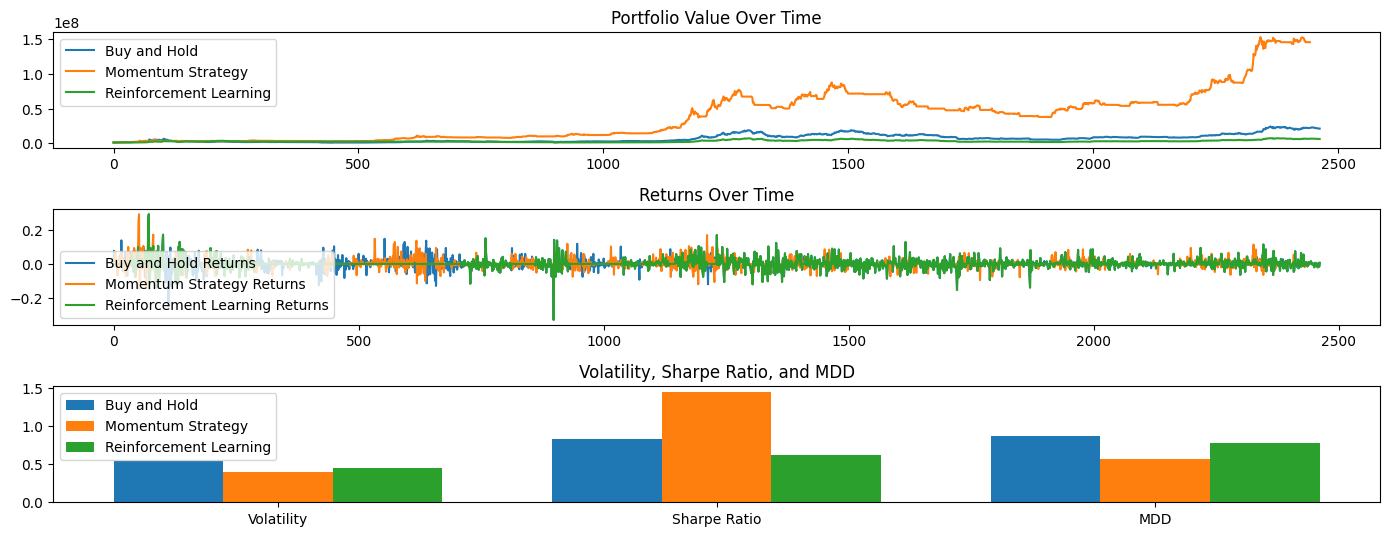

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Buy-and-Hold 전략
def simulate_buy_and_hold(data, initial_balance=1000000):
    initial_price = data.iloc[0]['close']
    portfolio = initial_balance / initial_price
    
    portfolio_values = []
    for i in range(len(data)):
        current_price = data.iloc[i]['close']
        total_value = portfolio * current_price
        portfolio_values.append(total_value)
    
    return np.array(portfolio_values)

buy_and_hold_values = simulate_buy_and_hold(df_cleaned)

# 모멘텀 전략
def momentum_strategy(data, lookback=20, initial_balance=1000000):
    data['return'] = data['close'].pct_change()
    data['momentum'] = data['return'].rolling(window=lookback).mean()

    balance = initial_balance
    portfolio = 0
    values = []

    for i in range(lookback, len(data)):
        current_price = data.iloc[i]['close']
        momentum = data.iloc[i]['momentum']

        # 모멘텀 신호가 양수이면 매수, 음수이면 매도
        if momentum > 0 and balance > 0:
            portfolio += balance / current_price
            balance = 0
        elif momentum < 0 and portfolio > 0:
            balance += portfolio * current_price
            portfolio = 0

        total_value = balance + portfolio * current_price
        values.append(total_value)
    
    return np.array(values)

momentum_values = momentum_strategy(df_cleaned)

# 강화학습 전략
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

class CryptoTradingEnv(gym.Env):
    def __init__(self, data):
        super(CryptoTradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.initial_balance = 1000000  # 초기 자본금
        self.balance = self.initial_balance
        self.portfolio = 0
        self.total_value = self.initial_balance

        # 관측 공간과 행동 공간 정의
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(6,), dtype=np.float32)
        self.action_space = spaces.Discrete(3)  # 세 가지 행동: 0=유지, 1=매수, 2=매도
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            np.random.seed(seed)
        self.balance = self.initial_balance
        self.portfolio = 0
        self.current_step = 0
        self.total_value = self.initial_balance
        return self._next_observation(), {}
    
    def _next_observation(self):
        obs = self.data.iloc[self.current_step][['open', 'high', 'low', 'close', 'volume']].to_numpy(dtype=np.float32)
        obs = np.append(obs, self.balance).astype(np.float32)
        return obs
    
    def step(self, action):
        self._take_action(action)
        self.current_step += 1
        if self.current_step >= len(self.data):
            self.current_step = 0

        obs = self._next_observation()
        reward = self.total_value - self.initial_balance
        terminated = bool(self.total_value <= 0)
        truncated = False  # 추가 종료 조건이 없는 경우 False로 설정
        return obs, float(reward), terminated, truncated, {}
    
    def _take_action(self, action):
        current_price = self.data.iloc[self.current_step]['close']
        if action == 1 and self.balance > 0:  # 매수
            self.portfolio += self.balance / current_price
            self.balance = 0
        elif action == 2 and self.portfolio > 0:  # 매도
            self.balance += self.portfolio * current_price
            self.portfolio = 0
        self.total_value = self.balance + self.portfolio * current_price

env = CryptoTradingEnv(df_cleaned)

# 환경 체크
check_env(env)

# 모델 정의 및 학습
model = DQN("MlpPolicy", env, verbose=1, learning_rate=1e-3, buffer_size=50000, learning_starts=1000, batch_size=32, tau=1e-2, target_update_interval=1000)
model.learn(total_timesteps=5000)

# 학습된 모델 저장
model.save("dqn_cryptotrading_model")

# 모델 로드
model = DQN.load("dqn_cryptotrading_model")

# 강화학습 모델의 포트폴리오 가치 계산
rl_values = []

obs, _ = env.reset()
for _ in range(len(df_cleaned)):
    action, _states = model.predict(obs)
    obs, rewards, terminated, truncated, _ = env.step(action)
    rl_values.append(env.total_value)
    if terminated or truncated:
        break

rl_values = np.array(rl_values)

# 성과 지표 계산
def calculate_returns(values):
    returns = (values[1:] - values[:-1]) / values[:-1]
    return returns

def calculate_sharpe_ratio(returns, risk_free_rate=0.01):
    excess_returns = returns - risk_free_rate / 252  # assuming daily returns
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    return sharpe_ratio

def calculate_mdd(values):
    peak = values[0]
    max_drawdown = 0
    for value in values:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        if drawdown > max_drawdown:
            max_drawdown = drawdown
    return max_drawdown

buy_and_hold_returns = calculate_returns(buy_and_hold_values)
momentum_returns = calculate_returns(momentum_values)
rl_returns = calculate_returns(rl_values)

buy_and_hold_volatility = np.std(buy_and_hold_returns) * np.sqrt(252)
momentum_volatility = np.std(momentum_returns) * np.sqrt(252)
rl_volatility = np.std(rl_returns) * np.sqrt(252)

buy_and_hold_sharpe = calculate_sharpe_ratio(buy_and_hold_returns)
momentum_sharpe = calculate_sharpe_ratio(momentum_returns)
rl_sharpe = calculate_sharpe_ratio(rl_returns)

buy_and_hold_mdd = calculate_mdd(buy_and_hold_values)
momentum_mdd = calculate_mdd(momentum_values)
rl_mdd = calculate_mdd(rl_values)

print(f"Buy-and-Hold 전략의 변동성: {buy_and_hold_volatility}")
print(f"모멘텀 전략의 변동성: {momentum_volatility}")
print(f"강화학습 모델의 변동성: {rl_volatility}")
print(f"Buy-and-Hold 전략의 샤프 지수: {buy_and_hold_sharpe}")
print(f"모멘텀 전략의 샤프 지수: {momentum_sharpe}")
print(f"강화학습 모델의 샤프 지수: {rl_sharpe}")
print(f"Buy-and-Hold 전략의 MDD: {buy_and_hold_mdd}")
print(f"모멘텀 전략의 MDD: {momentum_mdd}")
print(f"강화학습 모델의 MDD: {rl_mdd}")

# 시각화
plt.figure(figsize=(14, 7))

# 포트폴리오 가치 변화
plt.subplot(4, 1, 1)
plt.plot(buy_and_hold_values, label="Buy and Hold")
plt.plot(momentum_values, label="Momentum Strategy")
plt.plot(rl_values, label="Reinforcement Learning")
plt.title("Portfolio Value Over Time")
plt.legend()

# 수익률 변화
plt.subplot(4, 1, 2)
plt.plot(buy_and_hold_returns, label="Buy and Hold Returns")
plt.plot(momentum_returns, label="Momentum Strategy Returns")
plt.plot(rl_returns, label="Reinforcement Learning Returns")
plt.title("Returns Over Time")
plt.legend()

# 변동성 및 샤프 지수
metrics = ['Volatility', 'Sharpe Ratio', 'MDD']
buy_and_hold_metrics = [buy_and_hold_volatility, buy_and_hold_sharpe, buy_and_hold_mdd]
momentum_metrics = [momentum_volatility, momentum_sharpe, momentum_mdd]
rl_metrics = [rl_volatility, rl_sharpe, rl_mdd]

x = np.arange(len(metrics))
width = 0.25

plt.subplot(4, 1, 3)
plt.bar(x - width, buy_and_hold_metrics, width, label="Buy and Hold")
plt.bar(x, momentum_metrics, width, label="Momentum Strategy")
plt.bar(x + width, rl_metrics, width, label="Reinforcement Learning")
plt.title("Volatility, Sharpe Ratio, and MDD")
plt.xticks(x, metrics)
plt.legend()

plt.tight_layout()
plt.show()


In [55]:
df = pyupbit.get_ohlcv('KRW-BTC', interval="minute30", count=200000)


In [57]:
df_cleaned = df.dropna()

In [58]:

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from tqdm import tqdm
# 수수료 0.05% 반영, Min30 기준 거래
def simulate_buy_and_hold(data, initial_balance=1000000):
    initial_price = data.iloc[0]['close']
    portfolio = initial_balance / initial_price
    
    portfolio_values = []
    for i in range(len(data)):
        current_price = data.iloc[i]['close']
        total_value = portfolio * current_price
        portfolio_values.append(total_value)
    
    return np.array(portfolio_values)

buy_and_hold_values = simulate_buy_and_hold(df_cleaned)

def momentum_strategy(data, lookback=20, initial_balance=1000000, fee=0.0005):
    data['return'] = data['close'].pct_change()
    data['momentum'] = data['return'].rolling(window=lookback).mean()

    balance = initial_balance
    portfolio = 0
    values = []

    for i in range(lookback, len(data)):
        current_price = data.iloc[i]['close']
        momentum = data.iloc[i]['momentum']

        # 모멘텀 신호가 양수이면 매수, 음수이면 매도
        if momentum > 0 and balance > 0:
            portfolio += balance / current_price * (1 - fee)
            balance = 0
        elif momentum < 0 and portfolio > 0:
            balance += portfolio * current_price * (1 - fee)
            portfolio = 0

        total_value = balance + portfolio * current_price
        values.append(total_value)
    
    return np.array(values)

momentum_values = momentum_strategy(df_cleaned)



class CryptoTradingEnv(gym.Env):
    def __init__(self, data, fee=0.0005):
        super(CryptoTradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.initial_balance = 1000000  # 초기 자본금
        self.balance = self.initial_balance
        self.portfolio = 0
        self.total_value = self.initial_balance
        self.fee = fee  # 거래 수수료

        # 관측 공간과 행동 공간 정의
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(6,), dtype=np.float32)
        self.action_space = spaces.Discrete(3)  # 세 가지 행동: 0=유지, 1=매수, 2=매도
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            np.random.seed(seed)
        self.balance = self.initial_balance
        self.portfolio = 0
        self.current_step = 0
        self.total_value = self.initial_balance
        return self._next_observation(), {}
    
    def _next_observation(self):
        obs = self.data.iloc[self.current_step][['open', 'high', 'low', 'close', 'volume']].to_numpy(dtype=np.float32)
        obs = np.append(obs, self.balance).astype(np.float32)
        return obs
    
    def step(self, action):
        self._take_action(action)
        self.current_step += 1
        if self.current_step >= len(self.data):
            self.current_step = 0

        obs = self._next_observation()
        reward = self.total_value - self.initial_balance
        terminated = bool(self.total_value <= 0)
        truncated = False  # 추가 종료 조건이 없는 경우 False로 설정
        return obs, float(reward), terminated, truncated, {}
    
    def _take_action(self, action):
        current_price = self.data.iloc[self.current_step]['close']
        if action == 1 and self.balance > 0:  # 매수
            self.portfolio += (self.balance / current_price) * (1 - self.fee)
            self.balance = 0
        elif action == 2 and self.portfolio > 0:  # 매도
            self.balance += (self.portfolio * current_price) * (1 - self.fee)
            self.portfolio = 0
        self.total_value = self.balance + self.portfolio * current_price

env = CryptoTradingEnv(df_cleaned)

# 환경 체크
check_env(env)

# 모델 정의 및 학습
model = DQN("MlpPolicy", env, verbose=1, learning_rate=1e-3, buffer_size=50000, learning_starts=1000, batch_size=32, tau=1e-2, target_update_interval=1000)
model.learn(total_timesteps=5000)

# 학습된 모델 저장
model.save("dqn_cryptotrading_model")

# 모델 로드
model = DQN.load("dqn_cryptotrading_model")

# 강화학습 모델의 포트폴리오 가치 계산
rl_values = []

obs, _ = env.reset()
for _ in tqdm(range(len(df_cleaned))):
    action, _states = model.predict(obs)
    obs, rewards, terminated, truncated, _ = env.step(action)
    rl_values.append(env.total_value)
    if terminated or truncated:
        break

rl_values = np.array(rl_values)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Buy-and-Hold 전략의 변동성: 0.08755687954862841
모멘텀 전략의 변동성: 0.060045116681327414
강화학습 모델의 변동성: 0.010276834303727264
Buy-and-Hold 전략의 샤프 지수: -0.2238643785054034
모멘텀 전략의 샤프 지수: -0.7691055334215011
강화학습 모델의 샤프 지수: -3.342488410851029
Buy-and-Hold 전략의 MDD: 0.8762422521555456
모멘텀 전략의 MDD: 0.9998760244341214
강화학습 모델의 MDD: 0.8729132049423285


([<matplotlib.axis.XTick at 0x7fdd1f9e4820>,
 [Text(0, 0, 'Volatility'), Text(1, 0, 'Sharpe Ratio'), Text(2, 0, 'MDD')])

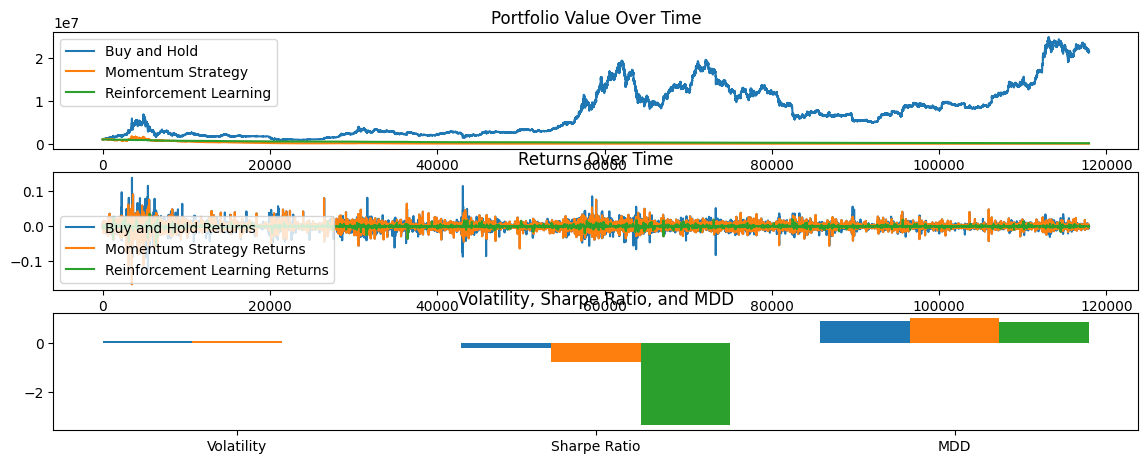

In [59]:
# 성과 지표 계산
def calculate_returns(values):
    returns = (values[1:] - values[:-1]) / values[:-1]
    return returns

def calculate_sharpe_ratio(returns, risk_free_rate=0.03):
    excess_returns = returns - risk_free_rate / 252  # assuming daily returns
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    return sharpe_ratio

def calculate_mdd(values):
    peak = values[0]
    max_drawdown = 0
    for value in values:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        if drawdown > max_drawdown:
            max_drawdown = drawdown
    return max_drawdown

buy_and_hold_returns = calculate_returns(buy_and_hold_values)
momentum_returns = calculate_returns(momentum_values)
rl_returns = calculate_returns(rl_values)

buy_and_hold_volatility = np.std(buy_and_hold_returns) * np.sqrt(252)
momentum_volatility = np.std(momentum_returns) * np.sqrt(252)
rl_volatility = np.std(rl_returns) * np.sqrt(252)

buy_and_hold_sharpe = calculate_sharpe_ratio(buy_and_hold_returns)
momentum_sharpe = calculate_sharpe_ratio(momentum_returns)
rl_sharpe = calculate_sharpe_ratio(rl_returns)

buy_and_hold_mdd = calculate_mdd(buy_and_hold_values)
momentum_mdd = calculate_mdd(momentum_values)
rl_mdd = calculate_mdd(rl_values)

print(f"Buy-and-Hold 전략의 변동성: {buy_and_hold_volatility}")
print(f"모멘텀 전략의 변동성: {momentum_volatility}")
print(f"강화학습 모델의 변동성: {rl_volatility}")
print(f"Buy-and-Hold 전략의 샤프 지수: {buy_and_hold_sharpe}")
print(f"모멘텀 전략의 샤프 지수: {momentum_sharpe}")
print(f"강화학습 모델의 샤프 지수: {rl_sharpe}")
print(f"Buy-and-Hold 전략의 MDD: {buy_and_hold_mdd}")
print(f"모멘텀 전략의 MDD: {momentum_mdd}")
print(f"강화학습 모델의 MDD: {rl_mdd}")

# 시각화
plt.figure(figsize=(14, 7))

# 포트폴리오 가치 변화
plt.subplot(4, 1, 1)
plt.plot(buy_and_hold_values, label="Buy and Hold")
plt.plot(momentum_values, label="Momentum Strategy")
plt.plot(rl_values, label="Reinforcement Learning")
plt.title("Portfolio Value Over Time")
plt.legend()

# 수익률 변화
plt.subplot(4, 1, 2)
plt.plot(buy_and_hold_returns, label="Buy and Hold Returns")
plt.plot(momentum_returns, label="Momentum Strategy Returns")
plt.plot(rl_returns, label="Reinforcement Learning Returns")
plt.title("Returns Over Time")
plt.legend()

# 변동성 및 샤프 지수
metrics = ['Volatility', 'Sharpe Ratio', 'MDD']
buy_and_hold_metrics = [buy_and_hold_volatility, buy_and_hold_sharpe, buy_and_hold_mdd]
momentum_metrics = [momentum_volatility, momentum_sharpe, momentum_mdd]
rl_metrics = [rl_volatility, rl_sharpe, rl_mdd]

x = np.arange(len(metrics))
width = 0.25

plt.subplot(4, 1, 3)
plt.bar(x - width, buy_and_hold_metrics, width, label="Buy and Hold")
plt.bar(x, momentum_metrics, width, label="Momentum Strategy")
plt.bar(x + width, rl_metrics, width, label="Reinforcement Learning")
plt.title("Volatility, Sharpe Ratio, and MDD")
plt.xticks(x, metrics)


In [60]:
df_cleaned.to_csv('30min_data.csv')